In [ ]:
!pip install kaggle

In [ ]:
!pip install pandas numpy matplotlib seaborn boto3 pyspark

In [ ]:
!kaggle datasets download jacksoncrow/stock-market-dataset

In [ ]:
import os
import zipfile
import gzip
import shutil

def get_size_gb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024 * 1024)

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

def compress_file(file_path, output_path):
    with open(file_path, 'rb') as f_in:
        with gzip.open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

def get_folder_size_gb(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size / (1024 * 1024 * 1024)

# File paths
zip_file = '/content/stock-market-dataset.zip'
extract_folder = '/content/stock-market-dataset'

# Check original zip file size
original_size = get_size_gb(zip_file)
print(f"Original zip file size: {original_size:.2f} GB")

# Unzip the file
unzip_file(zip_file, extract_folder)

# Get size after unzipping
unzipped_size = get_folder_size_gb(extract_folder)
print(f"Size after unzipping: {unzipped_size:.2f} GB")


In [21]:
AWS_ACCESS_KEY_ID = '' # Secret key
AWS_SECRET_ACCESS_KEY = '' # Secret Key
AWS_DEFAULT_REGION = '' # Your AWS region
MY_EMAIL = '' # Your Email
ACCOUNT_ID = '' # Your account ID

In [22]:
import boto3

# Set up session with AWS credentials
session = boto3.Session(
    aws_access_key_id= AWS_ACCESS_KEY_ID,
    aws_secret_access_key= AWS_SECRET_ACCESS_KEY,
    region_name= AWS_DEFAULT_REGION
)

s3 = session.client('s3')

In [ ]:
# Create s3 bucket
s3_bucket_name = 'stock-market-dataset'

s3.create_bucket(Bucket=s3_bucket_name, CreateBucketConfiguration={'LocationConstraint': AWS_DEFAULT_REGION})

print(f"Bucket {s3_bucket_name} created successfully!")

In [ ]:
from botocore.exceptions import NoCredentialsError

local_directory = '/content/stock-market-dataset'

def upload_directory_to_s3(local_directory, s3_bucket_name):
    """
    Recursively uploads all files in a local directory to an S3 bucket, preserving folder structure.

    Args:
        local_directory (str): The local directory to upload.
        s3_bucket_name (str): The name of the S3 bucket to upload to.
    """
    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_file_path = os.path.join(root, file)  # Full local path to the file
            relative_path = os.path.relpath(local_file_path, local_directory)  # Relative path for S3 key
            s3_key = relative_path.replace("\\", "/")  # Replace backslashes with forward slashes for S3

            try:
                # Upload the file
                s3.upload_file(local_file_path, s3_bucket_name, s3_key, ExtraArgs={'StorageClass': 'STANDARD_IA', 'ServerSideEncryption': 'AES256'})
                print(f"Uploaded {local_file_path} to s3://{s3_bucket_name}/{s3_key}")
            except FileNotFoundError:
                print(f"File {local_file_path} not found!")
            except NoCredentialsError:
                print("AWS credentials not available!")

# Call the function to start uploading
upload_directory_to_s3(local_directory, s3_bucket_name)


In [ ]:
import yfinance as yf
import pandas as pd

# Function to download daily data and save as CSV
def download_history(ticker_list, folder_name):
    for ticker in ticker_list:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="max")
            file_name = f"{folder_name}/{ticker}.csv"
            hist.to_csv(file_name)
            print(f"Downloaded data for {ticker} and saved to {file_name}")
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")

# List of top 100 stocks (can be adjusted to actual top 100 from another source)
top_100_stocks = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "FB", "TSLA", "BRK-B", "JPM", "JNJ", "V",
    "PG", "NVDA", "DIS", "MA", "PYPL", "VZ", "ADBE", "NFLX", "CMCSA", "PFE",
    "KO", "PEP", "NKE", "MRK", "T", "INTC", "XOM", "CSCO", "BA", "UNH",
    "MCD", "WMT", "ABT", "CVX", "COST", "MDT", "NEE", "LLY", "PM", "TMO",
    "DHR", "WFC", "IBM", "RTX", "ORCL", "C", "GS", "HON", "UPS", "QCOM", "SPGI",
    "AMGN", "TXN", "INTU", "MS", "LOW", "BLK", "BMY", "CAT", "SCHW", "MMM",
    "ZTS", "PLD", "BKNG", "AXP", "SBUX", "GILD", "CB", "ISRG", "USB", "MDLZ",
    "UNP", "BA", "TGT", "MU", "MO", "LMT", "CSX", "CI", "EL", "DE", "F",
    "TJX", "HUM", "MET", "CCI", "DUK", "APD", "EQIX", "TROW", "GM", "MMC",
    "PGR", "SYK", "ICE", "ECL", "FISV", "FDX", "ADI", "COP", "CME", "PSA", "DG"
]

# List of top 100 ETFs (can be adjusted to actual top 100 from another source)
top_100_etfs = [
    "SPY", "IVV", "VOO", "QQQ", "VTI", "VEA", "VWO", "IWM", "AGG", "BND",
    "GLD", "VIG", "LQD", "EFA", "SHY", "VNQ", "HYG", "IEF", "XLK", "VUG",
    "SCHX", "EEM", "VO", "IEFA", "IWF", "IJH", "XLF", "IWD", "XLV", "VTV",
    "VEU", "IWB", "IJR", "DIA", "ITOT", "XLI", "XLE", "VYM", "XLY", "XLP",
    "MBB", "SCHF", "VT", "BIV", "SPLG", "SCHB", "VHT", "SDY", "VOT", "EWJ",
    "TLT", "XLC", "XLU", "MTUM", "XBI", "BNDX", "VGT", "SPDW", "BNDW", "BSV",
    "IEMG", "SCHD", "VGK", "MUB", "GDX", "EWZ", "VB", "SPAB", "SCHR", "IGSB",
    "ACWI", "SLV", "ESGU", "SPTM", "SCHP", "XOP", "VTIP", "SCHF", "VFH", "SPYG",
    "IVW", "MGK", "XRT", "VOE", "RSP", "VBK", "VBR", "XLRE", "FDN", "FXI",
    "EWT", "EWG", "PFF", "FNDX", "EWU", "EMB", "PBD", "SCHH", "SCZ", "VCSH"
]

# Create folder names for stocks and ETFs
stock_folder = "stocks_data"
etf_folder = "etfs_data"

# Make directories if they don't exist
import os
os.makedirs(stock_folder, exist_ok=True)
os.makedirs(etf_folder, exist_ok=True)

# Download the historical data
print("Downloading stock data...")
download_history(top_100_stocks, stock_folder)

print("Downloading ETF data...")
download_history(top_100_etfs, etf_folder)

print("Data download completed!")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
import shutil

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Stock and ETF Data Transformation") \
    .getOrCreate()

# Define your S3 bucket and local directories
s3_bucket_name = 'stock-market-dataset'
stocks_folder_s3 = 'stocks/'
etfs_folder_s3 = 'etfs/'
local_stocks_directory = '/content/stocks_data'
local_etfs_directory = '/content/etfs_data'

def transform_and_save(file_path, output_dir):
    """
    Transform data by converting 'Date' column and dropping unwanted columns.
    Save the transformed data to the output directory.

    Args:
        file_path (str): The path to the input file.
        output_dir (str): The directory to save the transformed data.
    """
    # Read the data into a DataFrame
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Transform the data
    df_cleaned = df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd')) \
                   .drop('Dividends', 'Stock Splits')

    # Save the transformed data to a directory
    df_cleaned.write.mode('overwrite').csv(output_dir, header=True)
    print(f"Transformed data saved to {output_dir}")

def process_directory(local_directory, s3_folder):
    """
    Process files in the local directory, transform them, and save the results.

    Args:
        local_directory (str): The path to the local directory.
        s3_folder (str): The S3 folder where the files should be uploaded.
    """
    for root, dirs, files in os.walk(local_directory):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            output_dir = f'/tmp/cleaned_{file_name}_dir'

            # Create a directory for the transformed data
            os.makedirs(output_dir, exist_ok=True)

            transform_and_save(file_path, output_dir)

            # Upload files to S3
            for transformed_file in os.listdir(output_dir):
                file_path = os.path.join(output_dir, transformed_file)
                s3_key = f'{s3_folder}{file_name}/{transformed_file}'
                s3.upload_file(file_path, s3_bucket_name, s3_key)
                print(f"Uploaded {file_path} to s3://{s3_bucket_name}/{s3_key}")

            # Clean up the temporary directory
            shutil.rmtree(output_dir)
            print(f"Cleaned up temporary directory {output_dir}")

# Process stocks data
print("Processing stocks data:")
process_directory(local_stocks_directory, stocks_folder_s3)

# Process ETFs data
print("\nProcessing ETFs data:")
process_directory(local_etfs_directory, etfs_folder_s3)

# Stop the Spark session
spark.stop()


In [ ]:
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

def download_file_from_s3(bucket_name, s3_key, local_file_path):
    """
    Download a file from an S3 bucket to the local file system.

    Args:
        bucket_name (str): Name of the S3 bucket.
        s3_key (str): Key (path) of the file in S3.
        local_file_path (str): Local path where the file will be saved.
    """

    try:
        s3.download_file(bucket_name, s3_key, local_file_path)
        print(f"File downloaded successfully from s3://{bucket_name}/{s3_key} to {local_file_path}")
    except NoCredentialsError:
        print("Credentials not available.")
    except PartialCredentialsError:
        print("Incomplete credentials provided.")
    except Exception as e:
        print(f"Error downloading file: {e}")

# Example usage
bucket_name = 'stock-market-dataset'
s3_key = 'stocks/AMZN.csv'
local_file_path = 'AMZN.csv'

download_file_from_s3(bucket_name, s3_key, local_file_path)


In [5]:
import numpy as np

In [6]:
import pandas as pd

import matplotlib.pyplot as plt
amzn = pd.read_csv('/content/AMZN.csv')

In [ ]:
amzn.head()

In [ ]:
amzn.tail()

In [ ]:
amzn.describe()

In [ ]:
amzn.info()

In [11]:
amzn['Date']= pd.to_datetime(amzn['Date'])

In [12]:
amzn.set_index('Date', inplace=True)
amzn['diff'] = amzn['Open'] - amzn['Close']

In [ ]:

plt.figure(figsize=(14,10))
plt.plot(amzn['Close'])
plt.grid()
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price')
plt.show()

In [14]:
amzn = amzn.loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2024-01-01')]

In [ ]:
amzn.head()

In [ ]:
amzn.tail()

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(amzn['Close'])
plt.grid()
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price')
plt.show()

In [ ]:
daily_close = amzn[['Close']]
daily_pct_c = daily_close.pct_change()
daily_pct_c.fillna(0, inplace=True)
print(daily_pct_c)

In [ ]:
daily_pct_c.hist(bins=50)
plt.show()
print(daily_pct_c.describe())

In [ ]:
pd.plotting.scatter_matrix(daily_pct_c, diagonal='kde', alpha=0.1,figsize=(8,8))
plt.show()

In [ ]:
adj_close_px = amzn['Close']
amzn['50'] = adj_close_px.rolling(window=50).mean()
amzn['100'] = adj_close_px.rolling(window=100).mean()

plt.figure(figsize=(16,12))
plt.plot(amzn['Close'], label='Close')
plt.plot(amzn['50'], label='50')
plt.plot(amzn['100'], label='100')
plt.title('Simple Moving Average', fontsize=20)
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(adj_close_px, label='Close')
plt.plot(adj_close_px.ewm(span=50, adjust=False).mean(), label='50')
plt.plot(adj_close_px.ewm(span=100, adjust=False).mean(), label='100')
plt.title('Exponential Moving Average', fontsize=20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
min_periods = 75
vol = daily_pct_c.rolling(min_periods).std() * np.sqrt(min_periods)
plt.figure(figsize=(10, 8))
plt.plot(vol)
plt.title('Volatility of Amazon Stocks')
plt.show()

In [24]:
short_window = 13
long_window = 49

signals = pd.DataFrame(index=amzn.index)
signals['signal'] = 0.0

signals['short_mavg'] = amzn['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = amzn['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)

signals['positions'] = signals['signal'].diff()

In [ ]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111,  ylabel='Price ($)')
amzn['Close'].plot(ax=ax1, lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals.loc[signals.positions == 1.0].index,
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='red')
ax1.plot(signals.loc[signals.positions == -1.0].index,
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='black')
plt.show()

In [26]:
initial_capital= float(100000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AMZN'] = 100*signals['signal']
portfolio = positions.multiply(amzn['Close'], axis=0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(amzn['Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(amzn['Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

In [ ]:
portfolio.head()

In [ ]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index,
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index,
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')
plt.title('Portfolio Value in Time')
plt.show()

In [ ]:
!pip install optuna pmdarima

In [30]:
import datetime
import optuna

import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################

num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

stock_data = pd.read_csv('/content/AMZN.csv')

stock_data = pd.DataFrame(stock_data)
# Here I choose to only use the last 3 years of stock data
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['Open', 'High', 'Low', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    Ensure the index is in datetime format before extracting time features.
    """
    df = df.copy()

    # Convert the 'Date' column to datetime if it's not already
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)

    # Now create the time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df



In [31]:
df_xgb = stock_data.copy()

In [ ]:
df_xgb.head()

In [33]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(stock_data)

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [ ]:
# Drop 'Date' column if it exists, and ensure only numeric features are used
X = stock_data.drop(columns=['Date'])
y = stock_data['Close']  # Assuming 'Close' is the target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)


In [ ]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

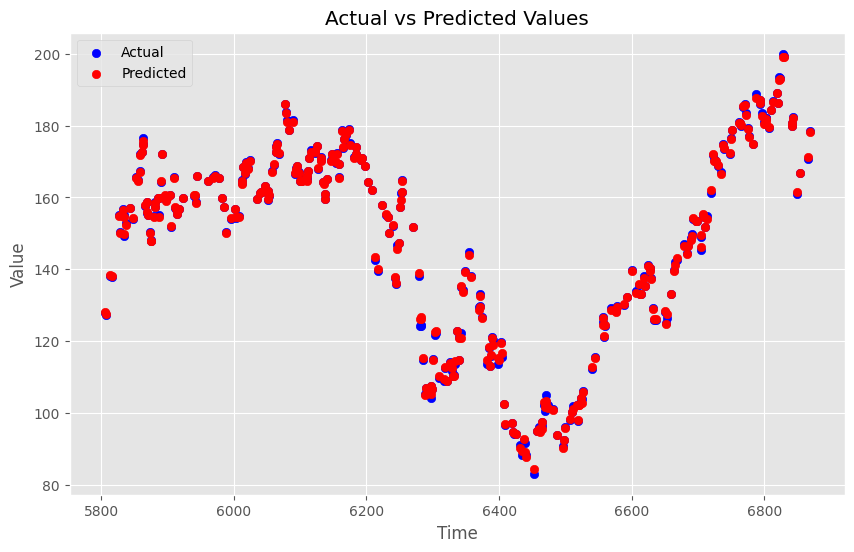

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

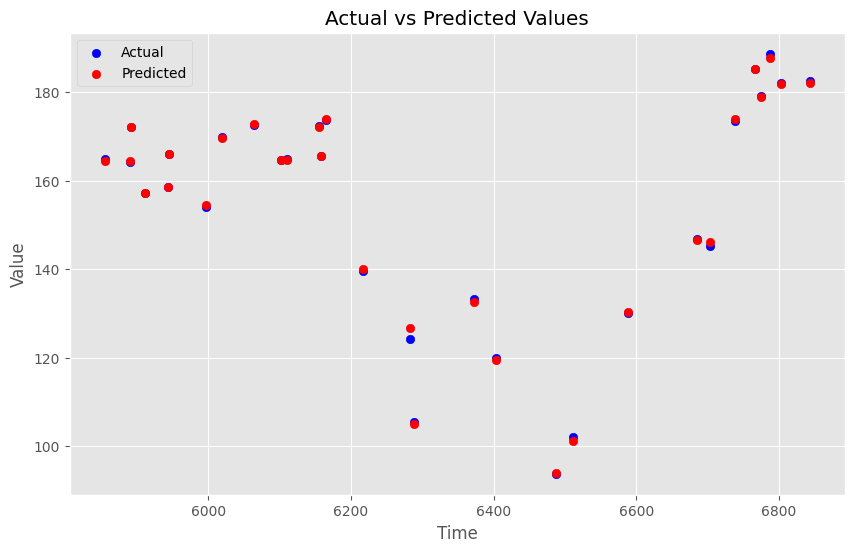

In [37]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Cost management
from datetime import datetime, timedelta

ce = session.client('ce')
# Define the time period (last 30 days)
end_date = datetime.utcnow().date()
start_date = (end_date - timedelta(days=30)).strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

# Query Cost Explorer for total costs
response = ce.get_cost_and_usage(
    TimePeriod={
        'Start': start_date,
        'End': end_date
    },
    Granularity='MONTHLY',  # or DAILY for finer granularity
    Metrics=['BlendedCost']
)

# Extract the cost data
costs = response['ResultsByTime'][0]['Total']['BlendedCost']['Amount']
unit = response['ResultsByTime'][0]['Total']['BlendedCost']['Unit']

print(f"Total AWS cost for the last 30 days: {costs} {unit}")

In [ ]:

sns = session.client('sns')
# Create a new SNS topic
response = sns.create_topic(Name='CostNotifications')
topic_arn = response['TopicArn']

# Subscribe your email to the topic
sns.subscribe(
    TopicArn=topic_arn,
    Protocol='email',
    Endpoint= MY_EMAIL # your email
)

# Publish a test message to the topic
sns.publish(
    TopicArn=topic_arn,
    Message='This is a test notification for cost monitoring',
    Subject='Cost Alert'
)

print("SNS setup and test notification sent")

In [27]:
# cloud watch

cloudwatch = session.client("cloudwatch")
bucket_name = "stock-market-dataset"
storage_type = "StandardStorage"

# Fetch S3 bucket size metrics
response = cloudwatch.get_metric_statistics(
    Namespace='AWS/S3',
    MetricName='BucketSizeBytes',
    Dimensions=[
        {
            'Name': 'BucketName',
            'Value': bucket_name
        },
        {
            'Name': 'StorageType',
            'Value': storage_type
        }
    ],
    StartTime=datetime.utcnow() - timedelta(days=1),
    EndTime=datetime.utcnow(),
    Period=86400,  # 1-day period
    Statistics=['Average']
)

# Display the bucket size
for data_point in response['Datapoints']:
    print(f"Average Bucket Size (in bytes): {data_point['Average']}")

In [ ]:
# Define the alarm threshold in bytes (e.g., 1 GB = 1 * 1024^3 bytes)
alarm_threshold = 1 * 1024**3  # 1 GB in bytes

response = cloudwatch.put_metric_alarm(
    AlarmName='S3BucketSizeAlarm',
    MetricName='BucketSizeBytes',
    Namespace='AWS/S3',
    Dimensions=[
        {
            'Name': 'BucketName',
            'Value': bucket_name
        },
        {
            'Name': 'StorageType',
            'Value': storage_type
        }
    ],
    Statistic='Average',
    Period=86400,  # Alarm checks once per day
    EvaluationPeriods=1,
    Threshold=alarm_threshold,
    ComparisonOperator='GreaterThanThreshold',
    AlarmActions=[f'arn:aws:sns:{AWS_DEFAULT_REGION}:{ACCOUNT_ID}:1-GB-exceeded'],
    AlarmDescription='Alarm when S3 bucket size exceeds 1 GB',
    ActionsEnabled=True
)

print(f"Alarm created: {response}")

In [ ]:
# Define the alarm threshold for object count (e.g., 10,000 objects)
object_threshold = 10000

response = cloudwatch.put_metric_alarm(
    AlarmName='S3ObjectCountAlarm',
    MetricName='NumberOfObjects',
    Namespace='AWS/S3',
    Dimensions=[
        {
            'Name': 'BucketName',
            'Value': bucket_name
        },
        {
            'Name': 'StorageType',
            'Value': storage_type
        }
    ],
    Statistic='Average',
    Period=86400,  # Alarm checks once per day
    EvaluationPeriods=1,
    Threshold=object_threshold,
    ComparisonOperator='GreaterThanThreshold',
    AlarmActions=[f'arn:aws:sns:{AWS_DEFAULT_REGION}:{ACCOUNT_ID}:greater-than-threshold'],
    AlarmDescription='Alarm when number of objects in S3 exceeds 10,000',
    ActionsEnabled=True
)

print(f"Alarm created: {response}")


In [31]:
# Create a new SNS topic
response = sns.create_topic(Name='S3AlarmsTopic')
topic_arn = response['TopicArn']
print(f"Created SNS topic: {topic_arn}")

# Subscribe an email to the topic
response = sns.subscribe(
    TopicArn=topic_arn,
    Protocol='email',
    Endpoint= MY_EMAIL
)

print(f"Subscription created: {response}")

Created SNS topic: arn:aws:sns:eu-north-1:716360905893:S3AlarmsTopic
Subscription created: {'SubscriptionArn': 'pending confirmation', 'ResponseMetadata': {'RequestId': 'cf31ee39-7ee7-5a7e-8313-b160ae1f2233', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'cf31ee39-7ee7-5a7e-8313-b160ae1f2233', 'date': 'Tue, 10 Sep 2024 04:44:40 GMT', 'content-type': 'text/xml', 'content-length': '298', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
